In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
resids = pd.Series.from_csv('residsNew.csv')
SASA = pd.read_csv('./PyMOL/2src_SASA.txt', header = None)
SASA.index = range(270, 520)

seq = "LRLEVKLGQGCFGEVWMGTWNGTTRVAIKTLKPGTMSPEAFLQEAQVMKKLRHEKLVQLYAVVSEEPIYIVTEYMSKGSLLDFLKGETGKYLRLPQLVDMAAQIASGMAYVERMNYVHRDLRAANILVGENLVCKVADFGLARLIEDNEYTARQGAKFPIKWTAPEAALYGRFTIKSDVWSFGILLTELTTKGRVPYPGMVNREVLDQVERGYRMPCPPECPESLHDLMCQCWRKEPEERPTFEYLQAFL"
seq = [AA for AA in seq]

SASA["Residue"] = seq

/anaconda2/lib/python2.7/site-packages/pandas/core/series.py:2890: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  infer_datetime_format=infer_datetime_format)


In [3]:
# Dictionary of one letter amino acid codes and its type
AA3idx = [
    'Ala',
    'Val',
    'Leu',
    'Ile',
    'Met',
    'Phe',
    'Tyr',
    'Trp',
    'Ser',
    'Thr',
    'Asn',
    'Gln',
    'Cys',
    'Asp',
    'Glu',
    'His',
    'Lys',
    'Arg',
    'Gly',
    'Pro',
    'Ter'
]

AA1idx = [
    'A',
    'V',
    'L',
    'I',
    'M',
    'F',
    'Y',
    'W',
    'S',
    'T',
    'N',
    'Q',
    'C',
    'D',
    'E',
    'H',
    'K',
    'R',
    'G',
    'P',
]
AAType = [
    'Hydrophobic',
    'Hydrophobic',
    'Hydrophobic',
    'Hydrophobic',
    'Hydrophobic',
    'Hydrophobic',
    'Hydrophobic',
    'Hydrophobic',
    'Polar',
    'Polar',
    'Polar',
    'Polar',
    'Polar',
    'Acidic',
    'Acidic',
    'Basic',
    'Basic',
    'Basic',
    'Hydrophobic',
    'Basic'
]
AAdict = dict(zip(AA1idx, AAType))
AA1idx.append('*')
AAdict1 = dict(zip(AA3idx, AA1idx))


def makeHeatMap(df):
    muts = df.index.tolist()
    heatMapDF = pd.DataFrame(index = AA1idx, columns = np.arange(270, 520))   # the residue numbers are hard coded here
    for mut in muts:
        heatMapDF.loc[AAdict1[mut[8:11]], int(mut[5:8])] = df[mut]
    return(heatMapDF)

In [4]:
# Create DataFrame of SASA, mean residuals, and variance of the residuals
dat = pd.DataFrame(index = range(270,520), columns = ['AA', 'Type', 'SASA', 'Location','Residuals', 'MeanResid', 'VarResid', 'MutNum'])

for mut in resids.index.tolist():
    resn = int(mut[5:8])
    if dat.loc[resn]['Residuals'] is np.nan:
        dat.loc[resn]['Residuals'] = []
    dat.loc[resn]['Residuals'].append(resids[mut])
    
dat['AA'] = seq
dat['SASA'] = SASA

for resi in dat.index.tolist():
    if dat.loc[resi]['Residuals'] is not np.nan:
        residList = dat.loc[resi]['Residuals']
        dat.loc[resi]['MeanResid'] = np.mean(residList)
        dat.loc[resi]['VarResid'] = np.var(residList)
        dat.loc[resi]['MutNum'] = len(residList)
    if dat.loc[resi]['SASA'] < 50:
        dat.loc[resi]['Location'] = 'Core'
    elif dat.loc[resi]['SASA'] < 100:
        dat.loc[resi]['Location'] = 'Boundary'
    else:
        dat.loc[resi]['Location'] = 'Surface'
    dat.loc[resi]['Type'] = AAdict[dat.loc[resi]['AA']]
dat.to_csv('SASA_MeanResid_VarResid_MutNum.csv')

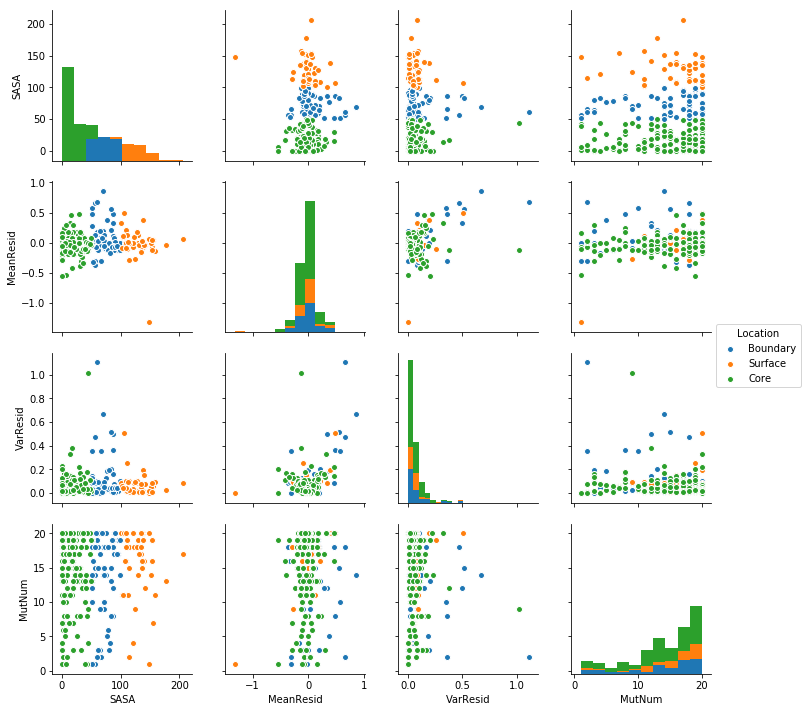

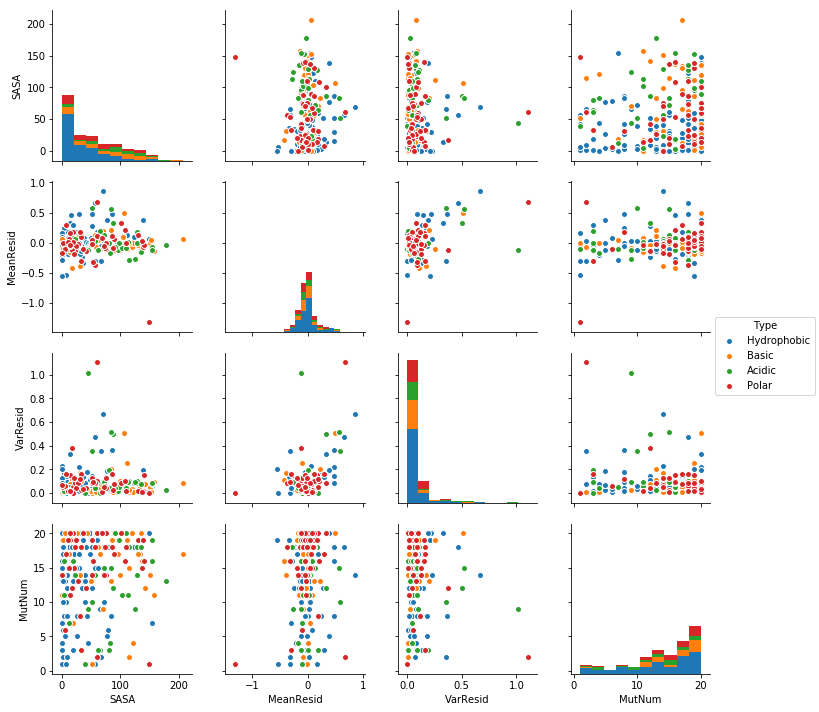

In [5]:
# Plot correlograms of SASA, MeanResid, VarResid, and MutNum categorized by location and AA type
SASACat = dat.loc[:, ['SASA', 'Location', 'MeanResid', 'VarResid', 'MutNum']]
sns.pairplot(SASACat,  hue = 'Location')
plt.show()

AACat = dat.loc[:, ['Type', 'SASA', 'MeanResid', 'VarResid', 'MutNum']]
sns.pairplot(AACat, hue = 'Type')
plt.show()

# 20190220: Making a heat map for labeling

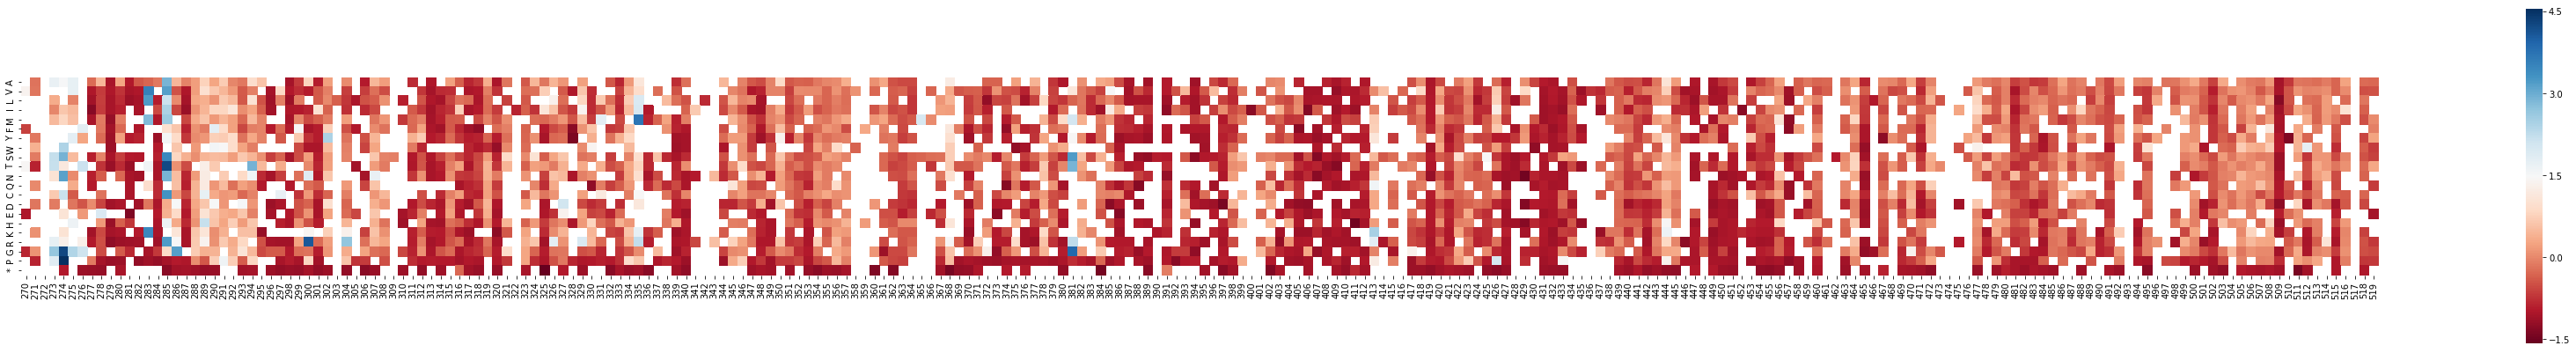

In [16]:
residMap = makeHeatMap(scores['Radicicol_score'])
plt.figure(figsize = (60, 20))
sns.heatmap(residMap.fillna(0), mask = residMap.isna(), square = True, cbar_kws = {"shrink": 0.35}, cmap = 'RdBu')
plt.show()

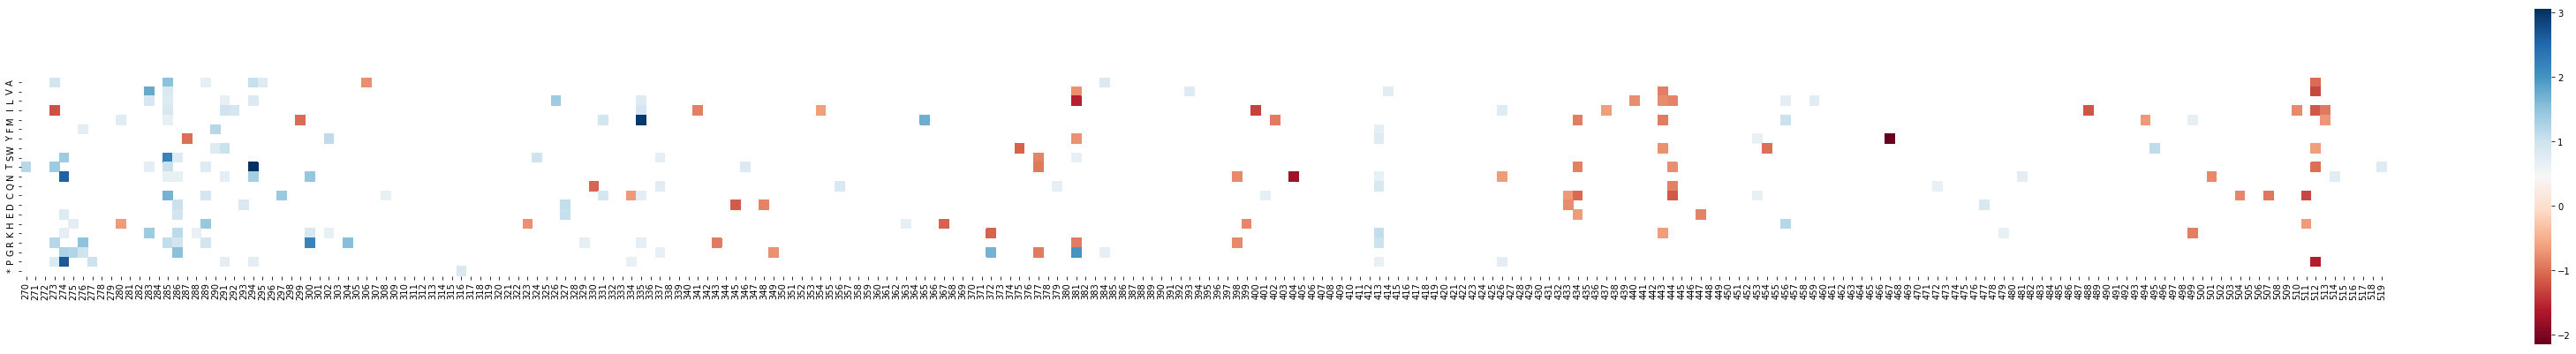

In [17]:
# Looking at tails of distribution
meanResid = np.mean(resids) # -1.871101793716647e-16
SDResid = np.std(resids)    # 0.3245443316967276
residLow = resids[resids < (meanResid - 1.96 * SDResid)] # 68 mutants
residHigh = resids[resids > (meanResid + 1.96 * SDResid)] # 121 mutants
tailResids = residLow.append(residHigh)

tailResidMap = residMap.copy()
tailResidMap[:] = np.nan
for mut in tailResids.index.tolist():
    resn = int(mut[5:8])
    resid = AAdict1[mut[8:11]]
    tailResidMap.loc[resid][resn] = tailResids[mut]

plt.figure(figsize = (60, 20))
sns.heatmap(tailResidMap.fillna(0), mask = tailResidMap.isna(), square = True, cbar_kws = {"shrink": 0.35}, cmap = "RdBu")
plt.show()

# 20190221: Residual vs DMSO plots

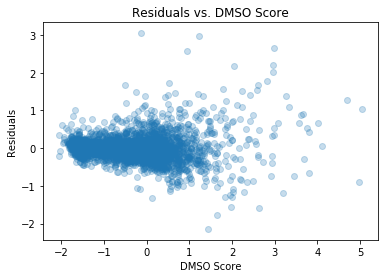

In [18]:
# Residuals vs DMSO
scores = pd.read_csv('./pointMuts_scores.csv', index_col = 0, header = 0)
plt.scatter(scores['Zero_score'], resids, alpha=0.25)
plt.xlabel('DMSO Score')
plt.ylabel('Residuals')
plt.title('Residuals vs. DMSO Score')
plt.show()

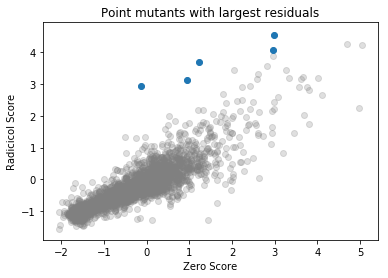

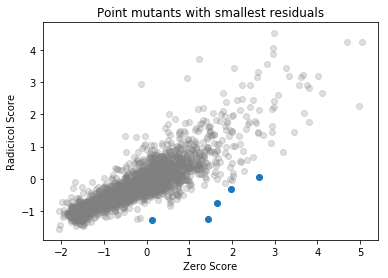

In [19]:
# Activity scores of point mutants that look interesting by the residual metric
largest = ['p.Arg294Thr', 'p.Glu335Met', 'p.Val274Pro', 'p.Val274Asn', 'p.Leu300Arg']
largestDF = scores.loc[largest]
plt.scatter(scores['Zero_score'], scores['Radicicol_score'], alpha = 0.25, color = 'gray')
plt.scatter(largestDF['Zero_score'], largestDF['Radicicol_score'])
plt.xlabel('Zero Score')
plt.ylabel('Radicicol Score')
plt.title('Point mutants with largest residuals')
plt.show()

smallest = ['p.Pro467Tyr', 'p.Lys404Asn', 'p.Phe512Pro', 'p.Glu381Leu', 'p.Asn400Ile']
smallestDF = scores.loc[smallest]
plt.scatter(scores['Zero_score'], scores['Radicicol_score'], alpha = 0.25, color = 'gray')
plt.scatter(smallestDF['Zero_score'], smallestDF['Radicicol_score'])
plt.xlabel('Zero Score')
plt.ylabel('Radicicol Score')
plt.title('Point mutants with smallest residuals')
plt.show()

In [20]:
# Residuals for Ethan's tested variants
testVars = ['p.Glu273Ile', 'p.Gly278Ser', 'p.Gln327Met', 'p.Glu273Arg', 'p.Met286Lys', 'p.Thr456His', 'p.Arg294Thr']
resids.loc[testVars]

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  This is separate from the ipykernel package so we can avoid doing imports until


p.Glu273Ile   -1.231413
p.Gly278Ser         NaN
p.Gln327Met    0.227354
p.Glu273Arg    1.191982
p.Met286Lys    1.151367
p.Thr456His    1.187099
p.Arg294Thr    3.061223
dtype: float64

In [21]:
scores.loc[testVars]

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


,Radicicol_score,Zero_score,Residuals
p.Glu273Ile,-0.023809,1.938920,-1.231413
p.Gly278Ser,NaN,NaN,NaN
p.Gln327Met,0.121637,-0.101392,0.227354
p.Glu273Arg,1.727359,0.894581,1.191982
p.Met286Lys,1.090838,-0.031190,1.151367
p.Thr456His,0.836609,-0.481660,1.187099
p.Arg294Thr,2.933289,-0.135907,3.061223


# 20190222: More heat maps, investigative ideas from reading

In [22]:
residMask = tailResidMap.notna()
zeroMap = makeHeatMap(scores['Zero_score'])
zeroMap = zeroMap * residMask
radMap = makeHeatMap(scores['Radicicol_score'])
radMap = radMap * residMask


In [23]:
plt.figure(figsize = (60, 20))
sns.heatmap(zeroMap.fillna(0), mask = mask, square = True, cbar_kws = {"shrink": 0.35},  cmap = "RdBu")
plt.show()

plt.figure(figsize = (60, 20))
sns.heatmap(radMap.fillna(0), mask = mask, square = True, cbar_kws = {"shrink": 0.35}, cmap = 'RdBu')
plt.show()

NameError: name 'mask' is not defined

<Figure size 4320x1440 with 0 Axes>

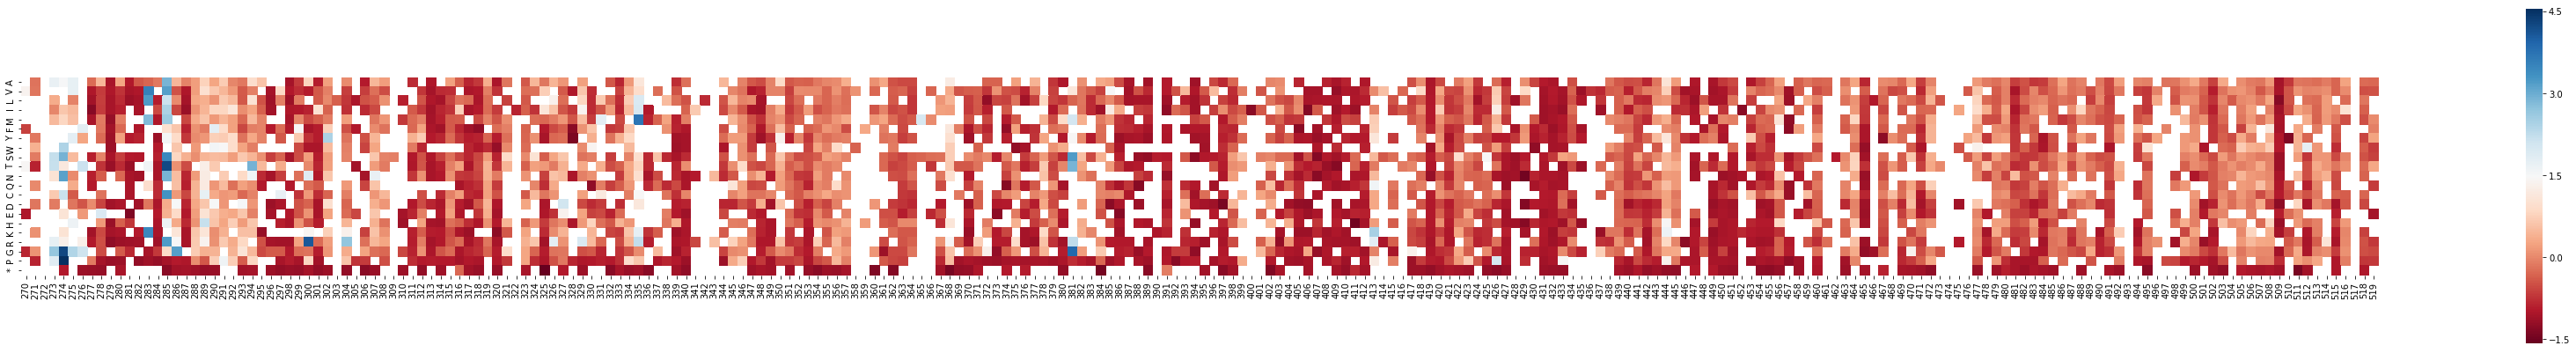

In [24]:
residMap = makeHeatMap(scores['Radicicol_score'])
plt.figure(figsize = (60, 20))
sns.heatmap(residMap.fillna(0), mask = residMap.isna(), square = True, cbar_kws = {"shrink": 0.35}, cmap = 'RdBu')
plt.show()

In [29]:
idx

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,


In [72]:
resi = 285
idx = [str(resi) in name for name in resids.index.tolist()]
resids[idx]

p.Trp285Ala    1.524540
p.Trp285Arg    1.104419
p.Trp285Asn    0.659137
p.Trp285Asp   -0.231146
p.Trp285Cys    1.682923
p.Trp285Glu   -0.379338
p.Trp285Gly    0.043812
p.Trp285His    0.500947
p.Trp285Ile    0.891464
p.Trp285Leu    0.783121
p.Trp285Met    0.662321
p.Trp285Phe    0.557019
p.Trp285Pro    0.039995
p.Trp285Ser    2.185180
p.Trp285Ter   -0.278979
p.Trp285Thr    1.031524
p.Trp285Tyr    0.085985
p.Trp285Val    0.875971
dtype: float64

In [73]:
tailResidMap[resi]

A     1.52454
V    0.875971
L    0.783121
I    0.891464
M    0.662321
F         NaN
Y         NaN
W         NaN
S     2.18518
T     1.03152
N    0.659137
Q         NaN
C     1.68292
D         NaN
E         NaN
H         NaN
K         NaN
R     1.10442
G         NaN
P         NaN
*         NaN
Name: 285, dtype: object

In [74]:
scores[idx]

,Radicicol_score,Zero_score,Residuals
p.Trp285Ala,2.914456,2.222153,1.524540
p.Trp285Arg,3.205861,3.327546,1.104419
p.Trp285Asn,2.908629,3.557549,0.659137
p.Trp285Asp,0.353119,0.970531,-0.231146
p.Trp285Cys,3.316906,2.601323,1.682923
p.Trp285Glu,0.385743,1.251438,-0.379338
p.Trp285Gly,0.891895,1.380386,0.043812
p.Trp285His,1.637419,1.828413,0.500947
p.Trp285Ile,2.451841,2.486973,0.891464
p.Trp285Leu,2.150735,2.187504,0.783121


In [75]:
af_idx = [
    'p.Glu381Val',
    'p.Glu381Leu',
    'p.Glu381Tyr',
    'p.Glu381Arg',
    'p.Thr443Val',
    'p.Thr443Leu',
    'p.Thr443Met',
    'p.Thr443Trp',
    'p.Thr443Lys',
    'p.Ile444Leu',
    'p.Ile444Thr',
    'p.Ile444Gln',
    'p.Ile444Cys',
    'p.Thr511Cys',
    'p.Thr511Cys',
    'p.Phe512Ala',
    'p.Phe512Val',
    'p.Phe512Ile',
    'p.Phe512Trp',
    'p.Phe512Thr',
    'p.Phe512Pro'
]
af_resids = scores.loc[af_idx]
af_resids.sort_values(by = ['Residuals'])

,Radicicol_score,Zero_score,Residuals
p.Phe512Pro,0.057222,2.636246,-1.599241
p.Glu381Leu,-0.333004,1.980951,-1.567662
p.Phe512Val,-0.048198,2.005892,-1.298911
p.Thr511Cys,-0.140425,1.838724,-1.283534
p.Thr511Cys,-0.140425,1.838724,-1.283534
p.Ile444Cys,0.250073,2.279161,-1.176539
p.Phe512Ile,0.083380,2.010465,-1.170276
p.Phe512Ala,-0.189100,1.345992,-1.015044
p.Phe512Thr,-0.495009,0.844805,-0.998346
p.Thr443Met,0.147173,1.708623,-0.912192


In [76]:
sh3_cd_idx = [
    'p.Trp289Ala',
    'p.Trp289Thr',
    'p.Trp289Cys',
    'p.Trp289His',
    'p.Trp289Arg',
    'p.Asn290Phe',
    'p.Asn290Trp',
    'p.Gly291Leu',
    'p.Gly291Ile',
    'p.Gly291Trp',
    'p.Gly291Asn',
    'p.Gly291Pro',
    'p.Thr293Asp',
]
sh3_resids = scores.loc[sh3_cd_idx]
sh3_resids.sort_values(by = ['Residuals'])

,Radicicol_score,Zero_score,Residuals
p.Gly291Leu,0.684013,0.098901,0.660804
p.Trp289Ala,0.782270,0.212555,0.685904
p.Gly291Asn,0.714388,0.070816,0.709257
p.Gly291Pro,1.611408,1.448196,0.719677
p.Trp289Thr,1.275079,0.808072,0.795387
p.Asn290Trp,1.569947,1.244974,0.809027
p.Thr293Asp,1.516220,1.123304,0.833618
p.Trp289Cys,1.724317,1.300196,0.927852
p.Trp289Arg,1.385917,0.749194,0.944123
p.Gly291Ile,0.824073,-0.197627,0.991735


# 20190403: Choosing control variants

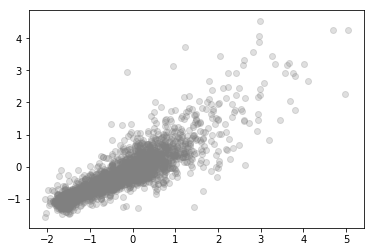

In [77]:
plt.scatter(scores['Zero_score'], scores['Radicicol_score'], alpha = 0.25, color = 'gray')
plt.show()

In [94]:
idx1 = scores['Zero_score'].values > 0
idx2 = scores['Radicicol_score'].values < -1
idx = np.logical_and(idx1, idx2)
control = scores.loc[idx]
control

,Radicicol_score,Zero_score,Residuals
p.Asn400Ile,-1.285306,0.117607,-1.320556
p.Pro467Tyr,-1.266538,1.444575,-2.155938


In [98]:
scores.loc[('p.Trp289His', 'p.Thr293Asp', 'p.Gly291Leu'), :]

,Radicicol_score,Zero_score,Residuals
p.Trp289His,2.176679,1.199606,1.444961
p.Thr293Asp,1.516220,1.123304,0.833618
p.Gly291Leu,0.684013,0.098901,0.660804
